# EVALUACIÓN DE ETIQUETADORES MORFOSINTÁCTICOS PARA EL ESPAÑOL

In [82]:
import inspect;
import pycrfsuite

import nltk
from nltk.corpus import cess_esp as cess
from nltk.tag import hmm
from nltk.tag import tnt
from nltk.tag.sequential import AffixTagger
from nltk.tag import brill, BigramTagger, BrillTaggerTrainer, CRFTagger, RegexpTagger, UnigramTagger
from nltk.tag.perceptron import PerceptronTagger
nltk.download('cess_esp')

import matplotlib.pyplot as plt

import numpy as np

import scipy as sp
import scipy.stats

import random
import time

[nltk_data] Downloading package cess_esp to /home/oem/nltk_data...
[nltk_data]   Package cess_esp is already up-to-date!


1.**Objetivos deltrabajo:**

* Conocer distintas herramientas de etiquetado morfosintáctico del paquete NLTK
* Aplicar   la   metodología   de   validación   cruzada   para   entrenar   y   evaluar etiquetadores morfosintácticos.
* Construir modelos de etiquetado morfosintáctico para el español a partir de corpus anotados
* Comparar las prestaciones de distintos etiquetadores incluyendointervalos de confianza

2.**Descripción del trabajo:**

El trabajo consiste  en  la  evaluación  de  las  prestaciones  dedistintosetiquetadores  morfosintácticos para uncorpus  del español(cess-esp).  En  esta  experimentación  se  estudiará  cómo  afectan  diversos parámetros  a  las  prestaciones  del  sistema:  el  tamaño  del  corpus  de  entrenamiento,  el  método  de suavizado para las palabras desconocidas, el juego de categorías morfosintácticas utilizado, etc.

Además,  se  compararán  las  prestaciones  de  distintos  etiquetadores  morfosintácticos  basados  en distintos paradigmas de aprendizaje.

Para ello,se utilizará el paquete NLTKque implementa diferentes etiquetadores morfosintácticos.

La evaluación de los etiquetadores se realizará mediante una validación cruzadasobre 10 partidoes del corpus.  Esta metodología consiste en dividir el corpus en 10 partes de similar tamaño, y ejecutar diez  experimentos.

En cada ejecución se  toman  9  partes  como  entrenamiento  y  1  como  prueba,  de manera que la parte de prueba siempre sea diferente.

La evaluación de las prestaciones del etiquetador es el resultado de calcular la media de la precisión de etiquetado (accuracy) sobre las distintas partidoes.

accuracy= número palabras etiquetadas correctamentedel test/ número total de palabrasdel test

IMPORTANTE:   Los   resultados   de accuracyobtenidos   deberán   presentarse   siempre   con el correspondiente intervalode confianza

## Funciones

In [47]:
def label_transform (lista):
    for position, item in enumerate(lista):
        if item[1].startswith('v') or item[1].startswith('F'):
            lista[position] = ( lista[position][0], item[1][:3] ) 
        else:
            lista[position] = ( lista[position][0] , item[1][:2] )
    return lista

def eliminarAnotaciones(lista):
    for idx,tagged_word in enumerate(lista):
        if tagged_word[0] == '*0*' or tagged_word[0] == 'sn':
            lista.pop(idx)
        else:
            pass
    
    return label_transform(lista)

def entrenar_prueba_dividir(lista,tamano_test=0):
    porc = 1-tamano_test
    porc_datos = int(len(lista)*porc)
    return ( lista[:porc_datos] ,  lista[porc_datos:] )

def validacion_cruzada(classificador,train_data,k):
    start_time = time.time()
    total = len(train_data) # Tamaño total de train_data
    particion = int(total/k) # Tamaño de cada partición (fold)
    fold = []
    tmp = []
    splits = []

    random.shuffle(train_data)
    recorrido = range(0,total,particion)
    for i in recorrido:
    if len(train_data[i:i+particion]) == particion:
        fold = train_data[i:i+particion]
        if i == 0:
            tmp = train_data[i+particion:]
        elif i < particion and i > 0:
            tmp = train_data[:i] + train_data[i+particion:]
        else:
            pass


    if type(classificador) == type(hmm.HiddenMarkovModelTrainer()):
        model = classificador.train_supervised(tmp)
        splits.append(model.evaluate(fold))
    else:
        classificador.train(tmp)
        splits.append(classificador.evaluate(fold))

    end_time = time.time() - start_time
  
    print("Tiempo:",  end_time)
    return splits

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m, m-h, m+h,h

def tabla(filas,columnas):
    fig, ax = plt.subplots()

    # hide axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    ax.table(cellText=filas, colLabels=columnas, loc='center')

    fig.tight_layout()

    plt.show()

### Corpus

In [48]:
oraciones_sin_procesar = cess.tagged_sents()
oraciones_procesadas = []

for i in oraciones_sin_procesar:
    procesada = eliminarAnotaciones(i)
    oraciones_procesadas.append(procesada)

train_completo, test_completo = entrenar_prueba_dividir(oraciones_sin_procesar, tamano_test=0.10)

train_reducido, test_reducido = entrenar_prueba_dividir(oraciones_procesadas, tamano_test=0.10)

# Tarea 1:

#### Evaluación del etiquetador ‘hmm’ sobre el corpus ‘cess-esp’ utilizando el juego de categorías completo y reducido.

Utilizando el etiquetador hmm basado en modelos de Markov, se realizará una validación cruzada sobre 10 partidoes del corpus. Barajar el corpus antes de realizar las partidoes. Presentar los resultados en forma de tabla y gráficamente, incluyendo los intervalos de confianza.

---  duración 350.02490282058716 segundos ---
---  duración 344.2557010650635 segundos ---


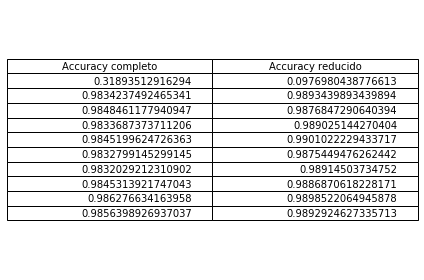

In [49]:
clf_Hmm = hmm.HiddenMarkovModelTrainer()

accuracys_completo = validacion_cruzada(clf_Hmm,list(oraciones_sin_procesar),10)
accuracys_reducido = validacion_cruzada(clf_Hmm,oraciones_procesadas,10)

tabla(np.array( [ accuracys_completo ,  accuracys_reducido ]).T, ["Accuracy completo","Accuracy reducido"] )

_, _, _, err_completo = mean_confidence_interval(accuracys_completo[1:])
_, _, _, err_reducido = mean_confidence_interval(accuracys_reducido[1:])


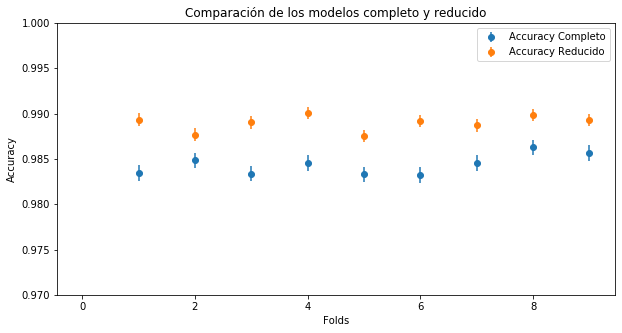

In [50]:
plt.figure(figsize=(10,5))
plt.errorbar(range(10), accuracys_completo,yerr=err_completo, fmt='o', label='Accuracy Completo')
plt.errorbar(range(10), accuracys_reducido,yerr=err_reducido, fmt='o', label='Accuracy Reducido')
plt.ylim(0.97, 1)
plt.title('Comparación de los modelos completo y reducido')
plt.xlabel('Folds')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


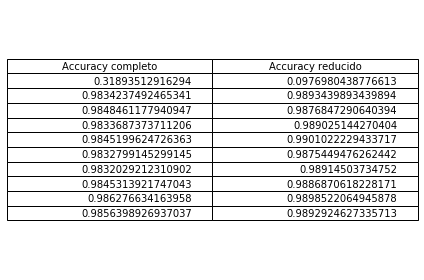

In [51]:
tabla(np.array( [ accuracys_completo ,  accuracys_reducido ]).T, ["Accuracy completo","Accuracy reducido"] )

# Tarea 2:

#### Evaluación de las prestaciones del etiquetador respecto a la cantidad de datos de aprendizaje.

Se trata de estudiar cómo varían las prestaciones del etiquetador hmm cuando varía el tamaño del corpus de aprendizaje. Para este experimento se dividirá el corpus de entrenamiento en 10 partes de tamaño similar. La partición 10 se tomará como test, y las 9 partidoes restantes se tomarán como entrenamiento. En cada ejecución, se irá incrementando sucesivamente el tamaño del corpus de entrenamiento, manteniendo fija la partición de test.

> **Importante:** Para esta tarea **no es necesario** realizar la validación cruzada.

Desde 0 Hasta  602  Accuracy:  0.127230736930506
Desde 0 Hasta  1205  Accuracy:  0.17284274616838127
Desde 0 Hasta  1808  Accuracy:  0.20680243543984883
Desde 0 Hasta  2411  Accuracy:  0.24333403317237035
Desde 0 Hasta  3014  Accuracy:  0.27393449506613476
Desde 0 Hasta  3617  Accuracy:  0.2975015746378333
Desde 0 Hasta  4220  Accuracy:  0.32615998320386314
Desde 0 Hasta  4823  Accuracy:  0.34279865630904893
Desde 0 Hasta  5426  Accuracy:  0.36830778920848206


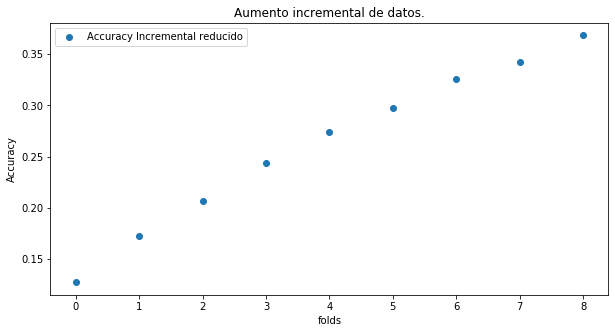

In [52]:
trainers = []
particion = int(len(oraciones_procesadas)/10)

y_acc = []
tmp = []

for i in range(0,len(oraciones_procesadas),particion):
    trainers.append( oraciones_procesadas[i:i+particion] )

for idx,i in enumerate(trainers[:9]):
    tmp += i
    clf_Hmm = hmm.HiddenMarkovModelTrainer()
    model = clf_Hmm.train_supervised(tmp)
    y_acc.append(model.evaluate(trainers[-1]))
    print("Desde 0 Hasta ",len(tmp) - 1," Accuracy: ",y_acc[idx])


# pintamos la gráfica.
plt.figure(figsize=(10,5))
plt.plot(range(9), y_acc, 'o', label='Accuracy Incremental reducido')
plt.title('Aumento incremental de datos.')
plt.xlabel('folds')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Tarea 3:

#### Evaluación del método de suavizado para palabras desconocidas para el etiquetador tnt.

El etiquetador tnt por defecto no incorpora un método de suavizado para las palabras desconocidas. Utiliza un método basado en los sufijos de las palabras para construir un modelo para las palabras desconocidas (Affix Tagger). En base al sufijo de la palabra desconocida le asigna una categoría morfosintáctica. Este método funciona razonablemente bien para el inglés.

En concreto, se trata de estudiar diferentes longitudes del sufijo (número de letras que se tienen en cuenta) y estudiar cómo varían las prestaciones del etiquetador. Una vez se haya decidido el sufijo que mejores prestaciones proporciona, incorporarlo como modelo de suavizado al etiquetador tnt y comprobar si aumenta sus prestaciones.

In [77]:
xlabels = []
accuracys = []

tnt_tagging = tnt.TnT()

tnt_tagging.train(train_reducido)

xlabels.append("Sin AffixTagger")

evaluacion = tnt_tagging.evaluate(test_reducido)

accuracys.append(evaluacion)

print("Accuracy TnT sin affix tagger", evaluacion)

Accuracy TnT sin affix tagger 0.8255173440524044


In [78]:
for i in range(-3,0):
    affix_tagger = AffixTagger(train=train_reducido,affix_length= i)
    tnt_tagging =  tnt.TnT(unk=affix_tagger,Trained=True)
    tnt_tagging.train(train_reducido)
    xlabels.append("Affix_Length "+str(i))
    evaluacion = tnt_tagging.evaluate(test_reducido)
    accuracys.append(evaluacion)
    print("Affix_Length = ",i," Accuracy: ", evaluacion)

Affix_Length =  -3  Accuracy:  0.9136519279440226
Affix_Length =  -2  Accuracy:  0.9055381866904868
Affix_Length =  -1  Accuracy:  0.8849933005806163


Accuracy TnT sin affix tagger 0.8849933005806163


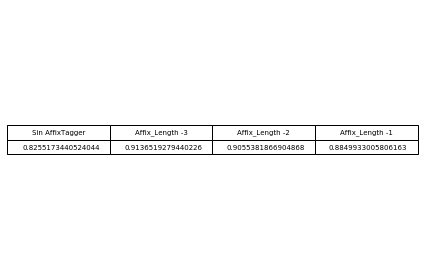

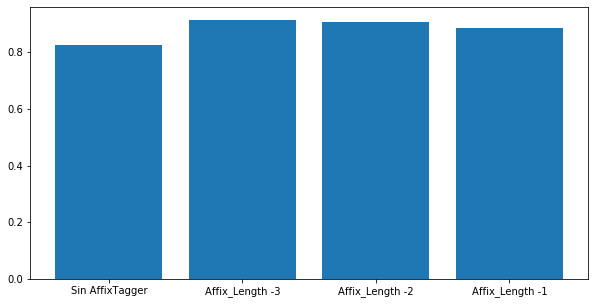

In [79]:
print("Accuracy TnT sin affix tagger", evaluacion) 
tabla([accuracys],xlabels)
plt.subplots(figsize=(10,5))
plt.bar(xlabels,accuracys)
plt.show()

# Tarea 4:

#### Evaluación del resto de etiquetadores.

Se deberán utilizar otros paradigmas de etiquetado. Como mínimo el etiquetador de Brill y algún otro como, CRF, perceptron. Se deberá realizar una comparativa de prestaciones respecto a los etiquetadores tnt y hmm, utilizando el juego de categorías reducido.

Cuando se utilice el etiquetador de Brill, probar con diferentes etiquetados iniciales, por ejemplo probar con Unigram Tagger y con hmm tagger.

La comparación puede ser sólo de una partición, si el coste temporal de la validación cruzada requiere mucho tiempo.

In [83]:
inspect.getfile(pycrfsuite)

'/home/oem/anaconda3/lib/python3.7/site-packages/pycrfsuite/__init__.py'

In [84]:
# inicializamos una lista vacia que contendra los nombres de los modelos para un diagrama de barras.
xlabels = []

# inicializamos una lista vacia que contendrá las preciciones de los modelos.
accuracys = []

# definimos un método para entrenar el modelo brill con el tagger especificado.
def entrenar_bill(initial_tagger,tagger_name):
    brill_tagger = BrillTaggerTrainer(initial_tagger=initial_tagger,templates=brill.brill24())
    tagger1 = brill_tagger.train(train_reducido[:1000])
    evaluacion = tagger1.evaluate(test_reducido[:1000])
    xlabels.append("Brill Tagger "+tagger_name)
    accuracys.append(evaluacion)

# instanciamos y entrenamos brill con el tagger Regexp basado en el ejemplo de uso del mismo.
tagger = RegexpTagger([
(r'^-?[0-9]+(.[0-9]+)?$', 'CD'),   # cardinal numbers
(r'(The|the|A|a|An|an)$', 'AT'),   # articles
(r'.*able$', 'JJ'),                # adjectives
(r'.*ness$', 'NN'),                # nouns formed from adjectives
(r'.*ly$', 'RB'),                  # adverbs
(r'.*s$', 'NNS'),                  # plural nouns
(r'.*ing$', 'VBG'),                # gerunds
(r'.*ed$', 'VBD'),                 # past tense verbs
(r'.*', 'NN')                      # nouns (default)
])
entrenar_bill(tagger,"RegexpTagger")

# instanciamos y entrenamos brill con el tagger Unigram.
tagger = UnigramTagger(train_reducido[:1000])
tagger.evaluate(test_reducido[:1000])
entrenar_bill(tagger,"UnigramTagger")

# instanciamos y entrenamos brill con el tagger Bigram.
tagger = BigramTagger(train_reducido[:1000])
tagger.evaluate(test_reducido[:1000])
entrenar_bill(tagger,"BigramTagger")

# instanciamos, entrenamos y evaluamos el modelo CRF Tagger.
from nltk.tag import CRFTagger
ct = CRFTagger()
ct.train(train_reducido[:1000],'model.crf.tagger')
evaluacion = ct.evaluate(test_reducido[:1000])
xlabels.append("CRF Tagger")
accuracys.append(evaluacion)

# instanciamos, entrenamos y evaluamos el modelo Perceptron Tagger.
from nltk.tag.perceptron import PerceptronTagger
tagger = PerceptronTagger(load=False)
tagger.train(train_reducido[:1000])
evaluacion = tagger.evaluate(test_reducido[:1000])
xlabels.append("Perceptron Tagger")
accuracys.append(evaluacion)

NameError: name 'pycrfsuite' is not defined

In [ ]:
# tabla
tabla([accuracys],xlabels)

# grafica
plt.subplots(figsize=(20,5))
plt.bar(xlabels,accuracys)
plt.ylabel("Accuracy")
plt.xlabel("Taggers")
plt.title("Comparación de Taggers")
plt.show()

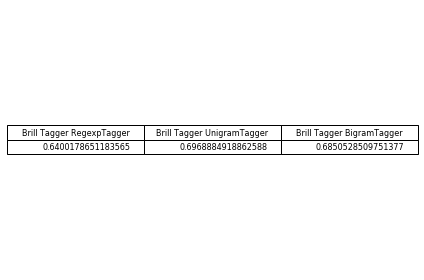

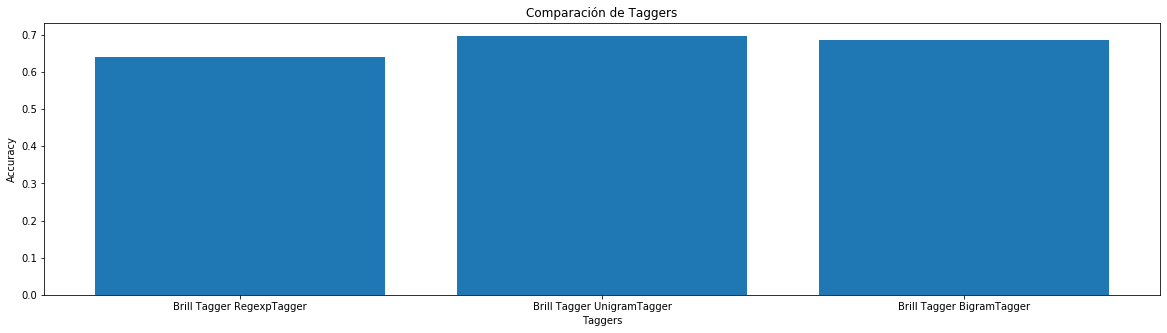